In [156]:
import torch
import torch.linalg as alg
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, HypergraphConv

from dataHandler import ParticleDataset
from manifold import PoincareManifold
poincare = PoincareManifold()

import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch
plt.style.use('dark_background')

In [157]:
def hyper_dist(point_a,point_b):
    #point_a = poincare._clip_vectors(point_a)
    #point_b = poincare._clip_vectors(point_b)

    #if len(point_a.shape) < 2:
    #    point_a = th.unsqueeze(point_a, 0)
    #if len(point_b.shape) < 2:
    #    point_b = th.unsqueeze(point_b, 0)

    sq_norm_a = alg.norm(point_a,axis=1) ** 2.
    sq_norm_b = alg.norm(point_b,axis=1) ** 2.
    sq_norm_ab = alg.norm(point_a - point_b,axis=1) ** 2.

    cosh_angle = 1 + 2 * sq_norm_ab / (1 - sq_norm_a) / (1 - sq_norm_b)
    cosh_angle = torch.clamp(cosh_angle, min=1.+1e-6)
    dist = torch.acosh(cosh_angle)
    return dist


def distance_matrix(nodes):
    matrix = torch.zeros(len(nodes),len(nodes))
    for n_idx in range(len(nodes)):
        #matrix[n_idx] = torch.cdist(torch.unsqueeze(nodes[n_idx],0),nodes)
        matrix[n_idx] = hyper_dist(torch.unsqueeze(nodes[n_idx],0),nodes) + 1e-8
    return matrix

def distance_matrix2(nodes):
    matrix = torch.zeros(len(nodes),len(nodes))
    for n_idx in range(len(nodes)):
        matrix[n_idx] = torch.cdist(torch.unsqueeze(nodes[n_idx],0),nodes)
        #matrix[n_idx] = poincare.distance(torch.unsqueeze(nodes[n_idx],0),nodes)
    return matrix

In [158]:
dataset = ParticleDataset('data/test/','background')
#data = dataset.__getitem__(0)
data_batches = DataLoader(dataset,batch_size=4,shuffle=False,num_workers=128)

In [159]:
class gnn(torch.nn.Module):
    def __init__(self,_in,_h1,_h2,_out):
        super().__init__()
        self.conv1 = HypergraphConv(_in,_h1,dropout=0.1)
        self.conv2 = HypergraphConv(_h1,_h2,dropout=0.1)
        self.conv3 = HypergraphConv(_h2,_out,dropout=0.1)
        
        self.epsilon = 1e-1
        self.thresh = 1.0 - self.epsilon
        
    def forward(self,data):
        x, edge_index = data.x, data.edge_index
        
        for row_id in range(len(x)):
            x[row_id] = poincare.exp_map(x[row_id],torch.zeros_like(x[0]))
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        
        '''
        norms = alg.norm(x,axis=1)
        if (norms < self.thresh).all() == False:
            x_copy = torch.clone(x)
            x_copy[norms >= self.thresh] *= (self.thresh / norms[norms >= self.thresh])[:,None]
            x = x_copy
        '''
        #x = poincare._clip_vectors(x)
        return x

In [160]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = gnn(4,64,64,2).to(device)
model.double()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [144]:
model.train()
torch.autograd.set_detect_anomaly(True)
for epoch in range(1):
    loss = []
    t = time()
    count = 0
    for batch in data_batches:
        optimizer.zero_grad()
        out = model(batch)
        loss_temp = 0
        for graph_idx in torch.unique(batch.batch):
            graph_mask = batch.batch == graph_idx
            _x = out[graph_mask]
            _y = batch.y[graph_mask]
            
            _input = distance_matrix(_x)
            _target = distance_matrix(_y)
        
            loss_temp += F.mse_loss(_input,_target)
            print(f'graph number: {count}, loss_temp: {loss_temp}')
            count+=1
        loss_temp /= batch.num_graphs    
        loss.append(loss_temp)
        
        loss_temp.backward()
        optimizer.step()
        print(f'batch:{count}, mean loss:{torch.mean(loss_temp.clone().detach())}, \
          time {round(time()-t,2)}')
        count+=1
        
    loss = torch.tensor(loss)
    print(f'epoch:{epoch}, mean loss:{torch.mean(loss.clone().detach())}, \
          time {round(time()-t,2)}')

graph number: 0, loss_temp: 6.707857608795166
graph number: 1, loss_temp: 13.596183776855469
graph number: 2, loss_temp: 20.743505477905273
graph number: 3, loss_temp: 26.82996940612793
batch:4, mean loss:6.707492351531982,           time 19.82
graph number: 5, loss_temp: 2.952507257461548
graph number: 6, loss_temp: 6.036515235900879
graph number: 7, loss_temp: 9.610318183898926
graph number: 8, loss_temp: 11.817001342773438
batch:9, mean loss:2.9542503356933594,           time 29.94
graph number: 10, loss_temp: 5.735039234161377
graph number: 11, loss_temp: 10.133493423461914
graph number: 12, loss_temp: 16.856407165527344
graph number: 13, loss_temp: 22.387880325317383
batch:14, mean loss:5.596970081329346,           time 39.4


Process Process-2601:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2adea3f093a0>
Traceback (most recent call last):
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/selectors.py",

KeyboardInterrupt: 

In [11]:
torch.save(model,'model_scripted.pt')

# Example 

loss is: 6.381307601928711


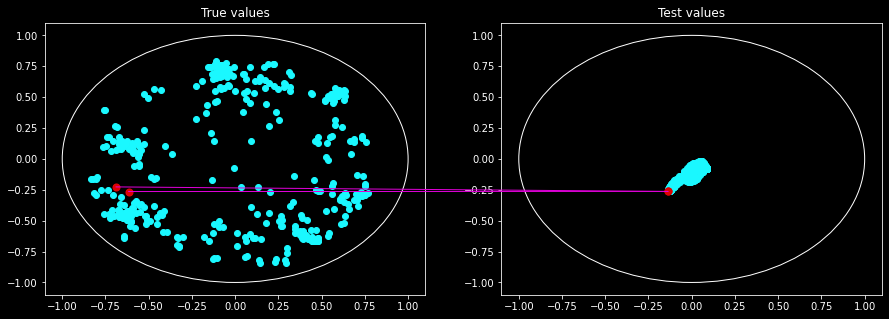

In [162]:
#model = torch.load('model_scripted.pt',map_location=torch.device('cpu'))
#model.eval()
data = dataset.__getitem__(0)
out = model(data)
#out = hgnn.hgnn(data)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()
ax[0].scatter(data.y[:,0],data.y[:,1],alpha=1,color='#1AF8FF')
ax[0].set_title('True values')

test = out.detach().clone()
ax[1].scatter(test[:,0],test[:,1],alpha=1,color='#1AF8FF')
ax[1].set_title('Test values')

disk = Circle((0,0),1,color='white',fill=False)
disk2 = Circle((0,0),1,color='white',fill=False)

ax[0].add_patch(disk)
ax[1].add_patch(disk2)

idxs = [0,1]
for idx00 in idxs:
    xy_left = data.y[idx00]
    xy_right = test[idx00]

    ax[0].scatter(xy_left[0],xy_left[1],alpha=1,color='#DF0101',s = 50)
    ax[1].scatter(xy_right[0],xy_right[1],s=50,c='#DF0101') #change color
    con = ConnectionPatch(xyA=xy_left, coordsA=ax[0].transData,xyB=xy_right, coordsB=ax[1].transData,color='#DF01D7')
    fig.add_artist(con)

length = len(out)
_input = distance_matrix(out)
_input = _input[torch.triu(torch.ones(length,length),diagonal=1) == 1]
_target = distance_matrix(data.y)
_target = _target[torch.triu(torch.ones(length,length),diagonal=1) == 1]
loss = F.mse_loss(_input,_target)
print(f'loss is: {loss}')
plt.show()

## pytorch_lightning

In [150]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar
import torch as th
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from dataHandler import ParticleDataset
#from graphNN import GNN

In [151]:
train = ParticleDataset('data/test','background')
train = DataLoader(train, batch_size=32, shuffle=True,num_workers=128)

test = ParticleDataset('data/test','background')
test = DataLoader(test, batch_size=32,num_workers=128)

In [152]:
class LitHGNN(pl.LightningModule):
    def __init__(self,model):
        super().__init__()
        self.hgnn = model(4,64,64,2)
        self.hgnn.double()
        
    def training_step(self,batch,batch_idx):
        output = self.hgnn(batch)
        
        
        loss = 0
        for graph_idx in th.unique(batch.batch):
            graph_mask = batch.batch == graph_idx
            _x = output[graph_mask]
            _y = batch.y[graph_mask]

            _input = distance_matrix(_x)
            _target = distance_matrix(_y)

            loss += F.mse_loss(_input,_target)

        loss /= batch.num_graphs
        
        #loss = F.mse_loss(output,batch.y)
        self.log('training loss',loss)
        return loss
    
    def test_step(self,batch,batch_idx):
        output = self.hgnn(batch)
        
        
        loss = 0
        for graph_idx in th.unique(batch.batch):
            graph_mask = batch.batch == graph_idx
            _x = output[graph_mask]
            _y = batch.y[graph_mask]

            _input = distance_matrix(_x)
            _target = distance_matrix(_y)
            
            loss += F.mse_loss(_input,_target)
        
        #loss = F.mse_loss(output,batch.y) 
        loss /= batch.num_graphs
        self.log('test loss',loss)
        
    def configure_optimizers(self):
        optimizer = th.optim.Adam(self.parameters(),lr=1e-2)
        return optimizer

In [153]:
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running training ...')
        return bar

In [154]:
hgnn = LitHGNN(gnn)
bar = LitProgressBar()

trainer = pl.Trainer(max_epochs=1,callbacks=[bar],log_every_n_steps=2)
trainer.fit(hgnn,train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type | Params
------------------------------
0 | hgnn | gnn  | 4.6 K 
------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.test(model=hgnn,test_dataloaders=test)

## Playing with my own gnn